## Autoregressive Integrated Moving Average

### General process to be followed:
1. Visualize the time series data
2. Make the data stationary
3. Plot the correlation and Autocorrelation charts
4. Construct the ARIMA or Seasonal ARIMA model based on the data
5. Use the model to make predictions.

#### Dataset: https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('monthly_champagne_sales.csv')

In [4]:
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
Month    105 non-null object
Sales    105 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


In [6]:
df.shape

(105, 2)

As can be seen, the Month column is not in datetime dtype. So we'll have to convert it

In [7]:
df.Month = pd.to_datetime(df.Month)

In [8]:
df.head()

,Month,Sales
0,1964-01-01,2815
1,1964-02-01,2672
2,1964-03-01,2755
3,1964-04-01,2721
4,1964-05-01,2946


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
Month    105 non-null datetime64[ns]
Sales    105 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.7 KB


Now it's in pandas datetime data type

Now we need to set the datetime type column as the index

In [10]:
df.set_index('Month', inplace=True)

In [11]:
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


### Step 2 : Visualization of Data

Let's plot the data now

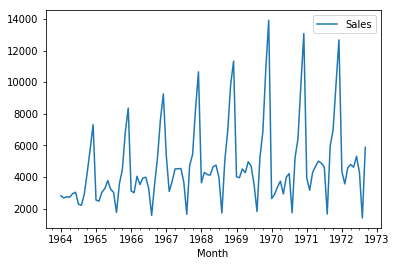

In [17]:
df.plot()

Now as visible from the pattern, the data looks seasonal. Now we need to test for stationarity

In [19]:
from statsmodels.tsa.stattools import adfuller

In [21]:
test_result = adfuller(df['Sales'])

Hypothesis :
    H0 = Data is non stationary;
    H1 = Data is stationary

In [23]:
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic', 'P-Value', '#Lags used', '#Observations used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1]<0.05:
        print('Strong evidence against the null hypothesis.\
              We reject the null hypothesis and conclude that data is stationary.')
    else:
        print('Weak evidence against the H0. We fail to reject H0. Data is non-Stationary.')

In [24]:
adfuller_test(df.Sales)

ADF Test Statistic : -1.8335930563276237
P-Value : 0.3639157716602447
#Lags used : 11
#Observations used : 93
Weak evidence against the H0. We fail to reject H0. Data is non-Stationary.


### Differencing

In [25]:
df['sales first difference'] = df['Sales'] - df['Sales'].shift()
df['seasonal_first_difference'] = df['Sales'] - df['Sales'].shift(12) # To remove seasonal Stationarity of 12 months

In [26]:
adfuller_test(df['seasonal_first_difference'].dropna())

ADF Test Statistic : -7.626619157213163
P-Value : 2.060579696813685e-11
#Lags used : 0
#Observations used : 92
Strong evidence against the null hypothesis.              We reject the null hypothesis and conclude that data is stationary.


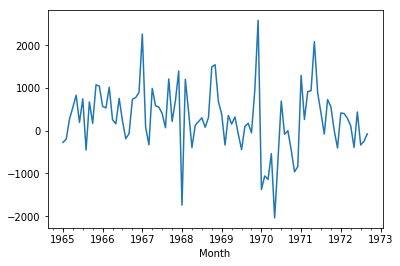

In [27]:
df['seasonal_first_difference'].plot()

Now data is stationary

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

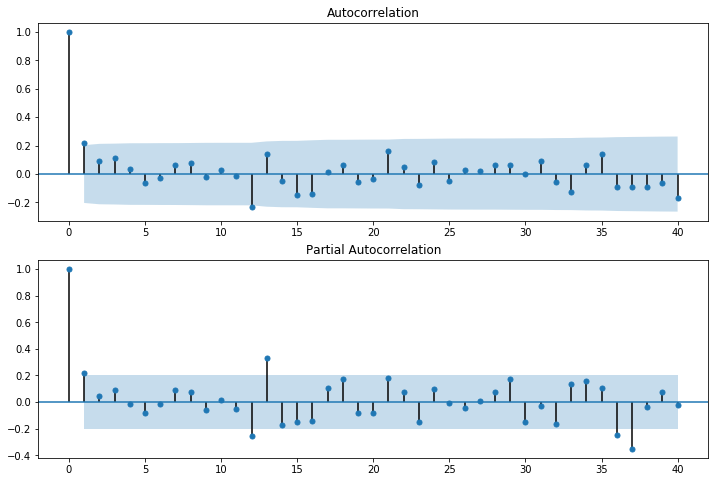

In [36]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['seasonal_first_difference'].dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['seasonal_first_difference'].dropna(), lags=40, ax=ax2)

So we will select p=1, q=1 and d=1

In [37]:
from statsmodels.tsa.arima_model import ARIMA

In [38]:
model = ARIMA(df['Sales'], order=(1,1,1))
model_fit = model.fit()

C:\Users\Chayan Kathuria\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Chayan Kathuria\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [39]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Sun, 24 May 2020   AIC                           1910.251
Time:                        23:54:40   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7854     12.405      1.837      0.069      -1.528      47.099
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

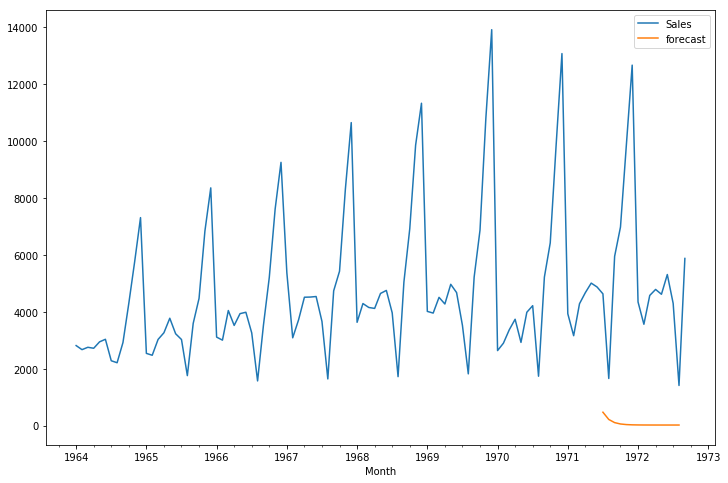

In [41]:
df['forecast'] = model_fit.predict(start=90, end=103, dynamic = True)
df[['Sales', 'forecast']].plot(figsize=(12,8))

As clearly visible, our model has performed utterly poorly.
This is due to the reason that the ARIMA is not suitable for seasonal data

Now, let's implement it using SARIMAX

In [42]:
import statsmodels.api as sm

In [43]:
model = sm.tsa.statespace.SARIMAX(df['Sales'], order = (1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()

C:\Users\Chayan Kathuria\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


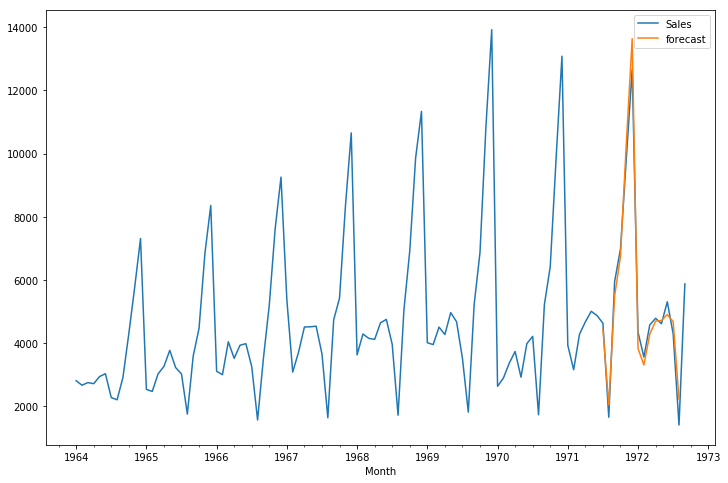

In [44]:
df['forecast'] = results.predict(start=90, end=103, dynamic = True)
df[['Sales', 'forecast']].plot(figsize=(12,8))

So as visible, the forecasting looks good. Now let's create some dummy future dates to test the performance

In [45]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,24)]

In [46]:
f_df = pd.DataFrame(index = future_dates, columns = df.columns)

In [47]:
f_df.head()

,Sales,sales first difference,seasonal_first_difference,forecast
1972-09-01,NaN,NaN,NaN,NaN
1972-10-01,NaN,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN,NaN


In [48]:
future_df = pd.concat([df, f_df])

In [52]:
future_df.tail()

,Sales,sales first difference,seasonal_first_difference,forecast
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN


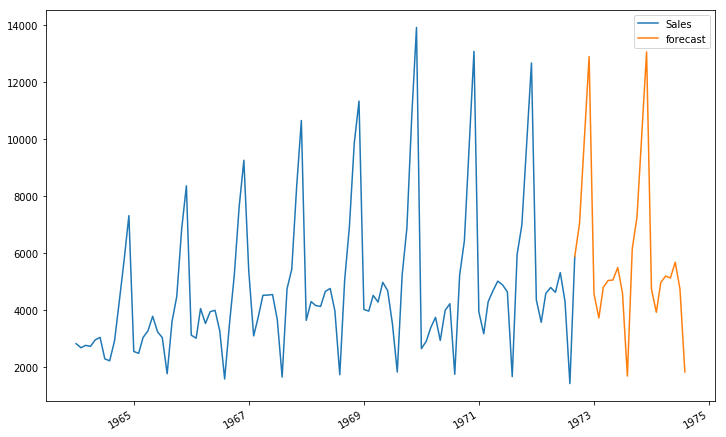

In [53]:
future_df['forecast'] = results.predict(start=104, end=129, dynamic=True)
future_df[['Sales', 'forecast']].plot(figsize=(12,8))

In [54]:
model = ARIMA(df['Sales'], order=(0,0,1))
model_fit = model.fit()

C:\Users\Chayan Kathuria\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


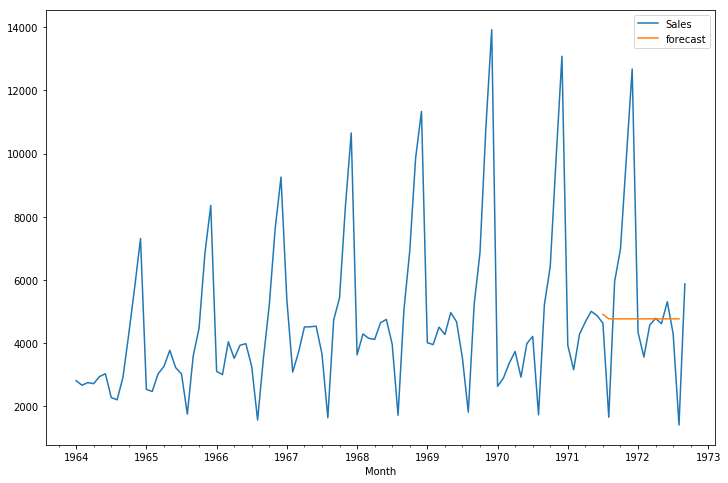

In [55]:
df['forecast'] = model_fit.predict(start=90, end=103, dynamic = True)
df[['Sales', 'forecast']].plot(figsize=(12,8))